# Инициализация необходимых библиотек

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc as sk_auc
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd
import joblib
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.model_selection import GridSearchCV

# Загрузка данных для обучения модели

In [9]:
df = pd.read_csv("data/Готовые данные.csv")

df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   comment                             1812 non-null   object 
 1   id                                  1812 non-null   float64
 2   rating                              1812 non-null   float64
 3   Вопрос решен                        1812 non-null   int64  
 4   Качество выполненной работы         1812 non-null   int64  
 5   Компетентность работника в общение  1812 non-null   int64  
 6   Не удовлетворен                     1812 non-null   int64  
 7   Скорость выполненной работы         1812 non-null   int64  
 8   Не понравился результат             1812 non-null   int64  
 9   Не понравилось качество             1812 non-null   int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 141.7+ KB


(                                        comment         id  rating  \
 0                                       спасибо  2945792.0     5.0   
 1                                      спасибо!  3234340.0     5.0   
 2                                      Отлично   3380332.0     5.0   
 3  Благодарю за оперативное решение проблемы !   3381812.0     5.0   
 4         Прекрасный специалист! Побольше таких  3461991.0     5.0   
 
    Вопрос решен  Качество выполненной работы  \
 0             1                            0   
 1             1                            0   
 2             1                            0   
 3             1                            0   
 4             1                            1   
 
    Компетентность работника в общение  Не удовлетворен  \
 0                                   0                0   
 1                                   0                0   
 2                                   0                0   
 3                                   0  

### Векторизация и разбиение данных для обучения модели

In [27]:
X_raw = df["comment"]
y = df.iloc[:, 3:]


# Векторизация текста
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X_raw)
X = X.toarray()
y_array = y.values.astype(int)

# Стратифицированное разбиение (70% train, 30% test)
X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, y_array, test_size=0.3
)

X_train_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_train).all(axis=1)))].reset_index(drop=True)
X_test_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_test).all(axis=1)))].reset_index(drop=True)

joblib.dump(vectorizer, "model/tfidf_vectorizer.pkl")

['model/tfidf_vectorizer.pkl']

### Logistic Regression

In [11]:
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__penalty': ['l2'],
    'estimator__solver': ['lbfgs'],
    'estimator__max_iter': [5000],
    'estimator__class_weight': ['balanced']
}

# Оборачиваем логистическую регрессию в MultiOutputClassifier
base_model = MultiOutputClassifier(LogisticRegression())

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучаем с подбором параметров
grid_search.fit(X_train, y_train)

# Используем лучшую модель из grid search
model = grid_search.best_estimator_

# Предсказания
y_pred = model.predict(X_test)

print("\nLogistic Regression")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values = []
f1_values = []
labels = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred[:, i])
        f1 = f1_score(y_test[:, i], y_pred[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values.append(auc_val)
        f1_values.append(f1)
        labels.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values:
    avg_roc_auc = np.mean(roc_auc_values)
    avg_f1 = np.mean(f1_values)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc:>10.3f} {avg_f1:>10.3f}")

# Предсказания вероятностей
y_proba_raw = model.predict_proba(X_test)
y_proba = np.array([proba[:, 1] for proba in y_proba_raw]).T

# Сохранение модели
joblib.dump(model, "model/logistic_model.pkl")

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Logistic Regression
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.850      0.954
Качество выполненной работы                   0.679      0.492
Компетентность работника в общение            0.742      0.559
Не удовлетворен                               0.873      0.675
Скорость выполненной работы                   0.900      0.886
Не понравился результат                       0.785      0.477
Не понравилось качество                       0.816      0.571
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.806      0.659


['model/logistic_model.pkl']

### График модели

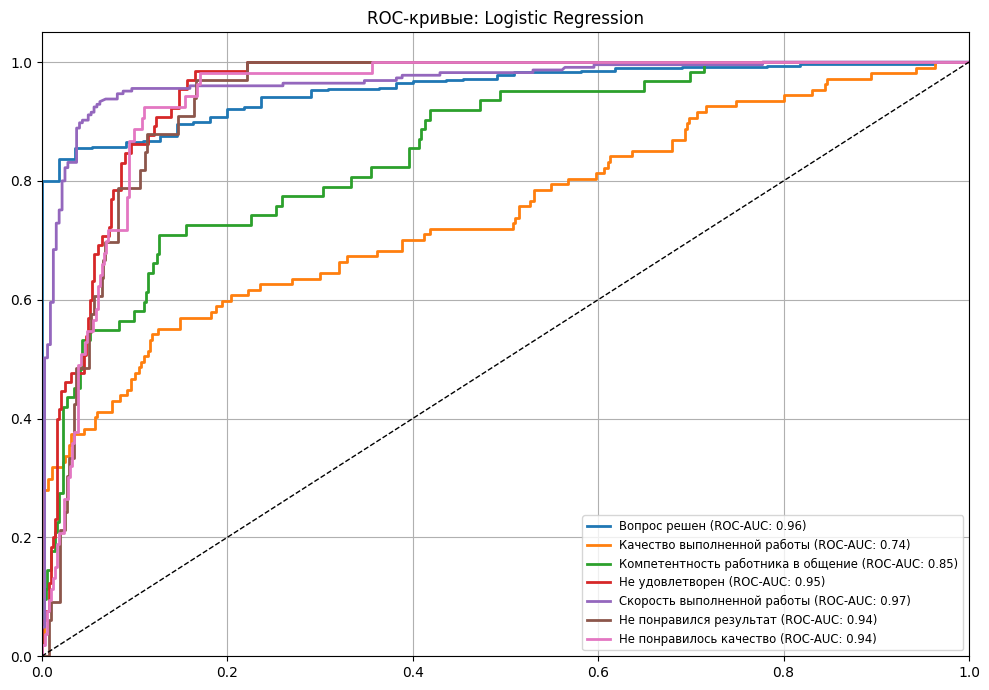

In [12]:
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Logistic Regression')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

### Проверка работы модели

In [13]:
model = joblib.load('model/logistic_model.pkl')
vectorizer = joblib.load("model/tfidf_vectorizer.pkl")

def predict_labels(text):
    X = vectorizer.transform([text])
    preds = model.predict(X)
    preds = preds[0]
    
    labels = ['Вопрос решен', 'Качество выполненной работы', 'Компетентность работника в общение', 'Не удовлетворен', 'Скорость выполненной работы', 'Не понравился результат', 'Не понравилось качество']
    
    # Формируем результат
    result = {label: bool(pred) for label, pred in zip(labels, preds)}
    return result

if __name__ == "__main__":
    while True:
        text = input("Введите сообщение для классификации (или 'exit' для выхода):\n")
        if text.lower() == 'exit':
            break
        prediction = predict_labels(text)
        print("Категории, выставленные моделью:")
        for cat, val in prediction.items():
            if val:
                print(f" - {cat}")

### Random Forest

In [14]:
param_grid_rf = {
    'estimator__n_estimators': [500, 1000, 1500],
    'estimator__max_depth': [None, 20, 50],
    'estimator__min_samples_split': [2, 5],
    'estimator__class_weight': ['balanced'],
    'estimator__random_state': [42]
}

# Обёртка для мульти-лейбл классификации
base_rf = MultiOutputClassifier(RandomForestClassifier())

# GridSearch
grid_search_rf = GridSearchCV(
    estimator=base_rf,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучение с подбором параметров
grid_search_rf.fit(X_train, y_train)

# Лучшая модель
rf_model = grid_search_rf.best_estimator_

# Предсказания
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values_rf = []
f1_values_rf = []
labels_rf = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred_rf[:, i])
        f1 = f1_score(y_test[:, i], y_pred_rf[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values_rf.append(auc_val)
        f1_values_rf.append(f1)
        labels_rf.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values_rf:
    avg_roc_auc_rf = np.mean(roc_auc_values_rf)
    avg_f1_rf = np.mean(f1_values_rf)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc_rf:>10.3f} {avg_f1_rf:>10.3f}")

# Предсказания вероятностей
y_proba_raw_rf = rf_model.predict_proba(X_test)
y_proba_rf = np.array([proba[:, 1] for proba in y_proba_raw_rf]).T

# Сохранение модели
joblib.dump(rf_model, "model/random_forest_model.pkl")

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Random Forest
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.790      0.959
Качество выполненной работы                   0.684      0.518
Компетентность работника в общение            0.629      0.391
Не удовлетворен                               0.770      0.586
Скорость выполненной работы                   0.918      0.906
Не понравился результат                       0.689      0.394
Не понравилось качество                       0.761      0.571
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.748      0.618


['model/random_forest_model.pkl']

### График модели

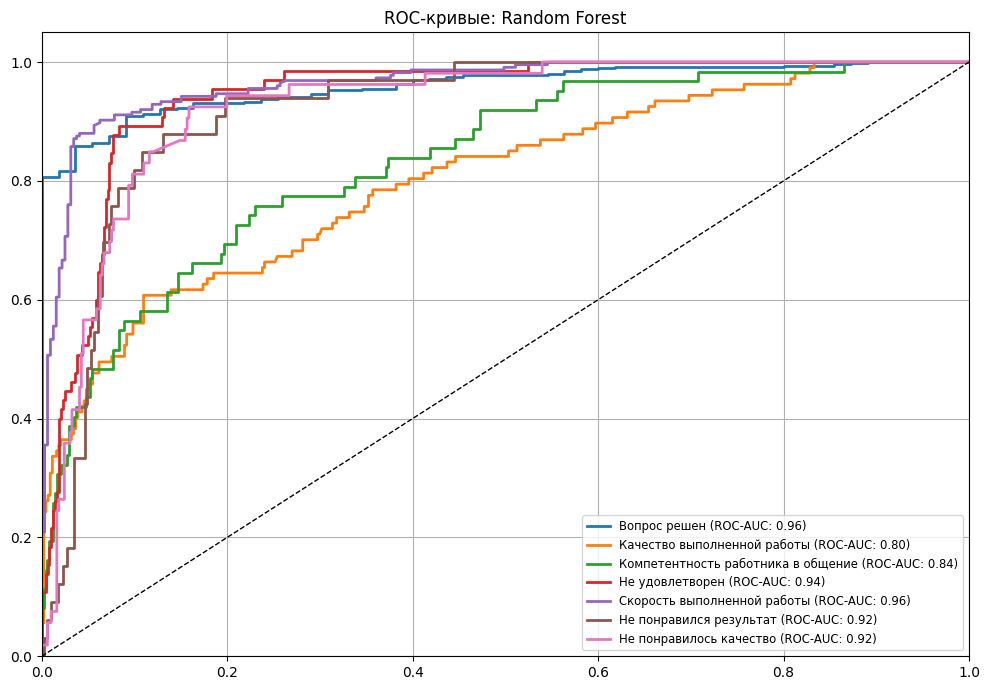

In [15]:
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba_rf[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Random Forest')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


### Проверка работы модели

In [16]:
rf_model = joblib.load("model/random_forest_model.pkl")
vectorizer = joblib.load("model/tfidf_vectorizer.pkl")

labels = ['Вопрос решен', 'Качество выполненной работы', 'Компетентность работника в общение', 'Не удовлетворен', 'Скорость выполненной работы', 'Не понравился результат', 'Не понравилось качество']

def predict_labels(text):
    X = vectorizer.transform([text])
    preds = rf_model.predict(X)[0]  # Получаем массив предсказаний для 1 примера
    result = {label: bool(pred) for label, pred in zip(labels, preds)}
    return result

if __name__ == "__main__":
    while True:
        text = input("Введите сообщение для классификации (или 'exit' для выхода):\n")
        if text.lower() == 'exit':
            break
        prediction = predict_labels(text)
        print("Категории, выставленные моделью:")
        for cat, val in prediction.items():
            if val:
                print(f" - {cat}")

### Linear SVC

In [25]:
param_grid_svc = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__class_weight': ['balanced'],
    'estimator__max_iter': [10000]
}

# Базовая модель
base_svc = OneVsRestClassifier(LinearSVC())

# GridSearch
grid_search_svc = GridSearchCV(
    estimator=base_svc,
    param_grid=param_grid_svc,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучение с подбором параметров
grid_search_svc.fit(X_train, y_train)

# Лучшая модель
svc_model = grid_search_svc.best_estimator_

# Предсказания
y_pred_svc = svc_model.predict(X_test)

print("\nLinear SVC")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values_svc = []
f1_values_svc = []
labels_svc = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred_svc[:, i])
        f1 = f1_score(y_test[:, i], y_pred_svc[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values_svc.append(auc_val)
        f1_values_svc.append(f1)
        labels_svc.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values_svc:
    avg_roc_auc_svc = np.mean(roc_auc_values_svc)
    avg_f1_svc = np.mean(f1_values_svc)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc_svc:>10.3f} {avg_f1_svc:>10.3f}")

# Получаем decision_function (shape [n_samples, n_classes])
y_scores = svc_model.decision_function(X_test)

# Применяем сигмоиду для перевода в вероятности
y_proba_svc = expit(y_scores)

# Сохранение модели
joblib.dump(svc_model, "model/linear_svc_model.pkl")

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Linear SVC
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.848      0.952
Качество выполненной работы                   0.675      0.487
Компетентность работника в общение            0.742      0.559
Не удовлетворен                               0.867      0.655
Скорость выполненной работы                   0.895      0.881
Не понравился результат                       0.797      0.478
Не понравилось качество                       0.842      0.594
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.810      0.658


['model/linear_svc_model.pkl']

### График модели

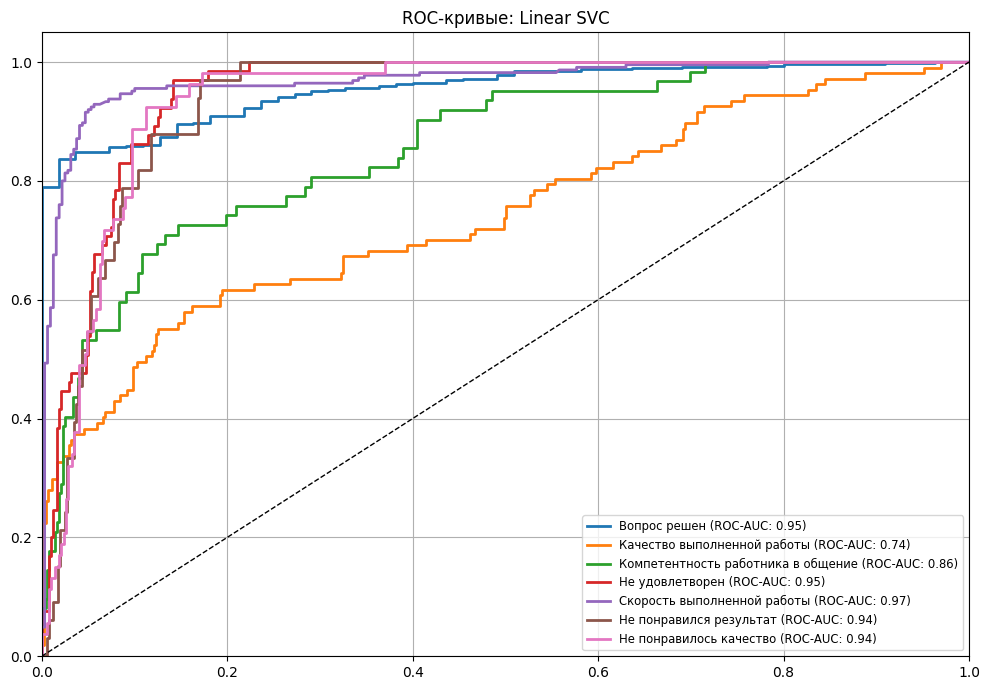

In [18]:
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba_svc[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Linear SVC')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

### Проверка работы модели

In [28]:
svc_model = joblib.load("model/linear_svc_model.pkl")
vectorizer = joblib.load("model/tfidf_vectorizer.pkl")

labels = ['Вопрос решен', 'Качество выполненной работы', 'Компетентность работника в общение', 'Не удовлетворен', 'Скорость выполненной работы', 'Не понравился результат', 'Не понравилось качество']

def predict_labels(text, threshold=0.5):
    X = vectorizer.transform([text])
    # Получаем decision_function (оценки)
    scores = svc_model.decision_function(X)[0]  # для одного примера
    # Применяем сигмоиду для вероятностей
    probs = expit(scores)
    # Выбираем метки, где вероятность выше порога
    result = {label: (prob > threshold) for label, prob in zip(labels, probs)}
    return result

if __name__ == "__main__":
    while True:
        text = input("Введите сообщение для классификации (или 'exit' для выхода):\n")
        if text.lower() == 'exit':
            break
        prediction = predict_labels(text)
        print("Категории, выставленные моделью:")
        for cat, val in prediction.items():
            if val:
                print(f" - {cat}")

Категории, выставленные моделью:
 - Вопрос решен
Категории, выставленные моделью:
 - Вопрос решен
 - Качество выполненной работы
 - Скорость выполненной работы
Категории, выставленные моделью:
 - Вопрос решен


### CatBoostClassifier

In [23]:
base_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    verbose=0
)

# Обёртка
wrapped_model = MultiOutputClassifier(base_model)

# Сетка параметров
param_grid_catboost = {
    'estimator__iterations': [500, 1000],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__depth': [4, 6, 8]
}

# GridSearch
grid_search_cb = GridSearchCV(
    estimator=wrapped_model,
    param_grid=param_grid_catboost,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучение
grid_search_cb.fit(X_train, y_train)

# Лучшая модель
model = grid_search_cb.best_estimator_

# Предсказания (класс)
y_pred = model.predict(X_test)

print("\nCatBoostClassifier")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values = []
f1_values = []
labels = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred[:, i])
        f1 = f1_score(y_test[:, i], y_pred[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values.append(auc_val)
        f1_values.append(f1)
        labels.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values:
    avg_roc_auc = np.mean(roc_auc_values)
    avg_f1 = np.mean(f1_values)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc:>10.3f} {avg_f1:>10.3f}")

# Получаем вероятности для положительного класса
# predict_proba для MultiOutputClassifier возвращает список массивов
y_proba_list = model.predict_proba(X_test)
y_proba = np.array([proba[:, 1] for proba in y_proba_list]).T

# Сохранение модели
joblib.dump(model, "model/catboost_model.pkl")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

CatBoostClassifier
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.765      0.951
Качество выполненной работы                   0.696      0.523
Компетентность работника в общение            0.734      0.574
Не удовлетворен                               0.777      0.597
Скорость выполненной работы                   0.928      0.916
Не понравился результат                       0.670      0.351
Не понравилось качество                       0.752      0.531
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.760      0.635


['model/catboost_model.pkl']

### График модели

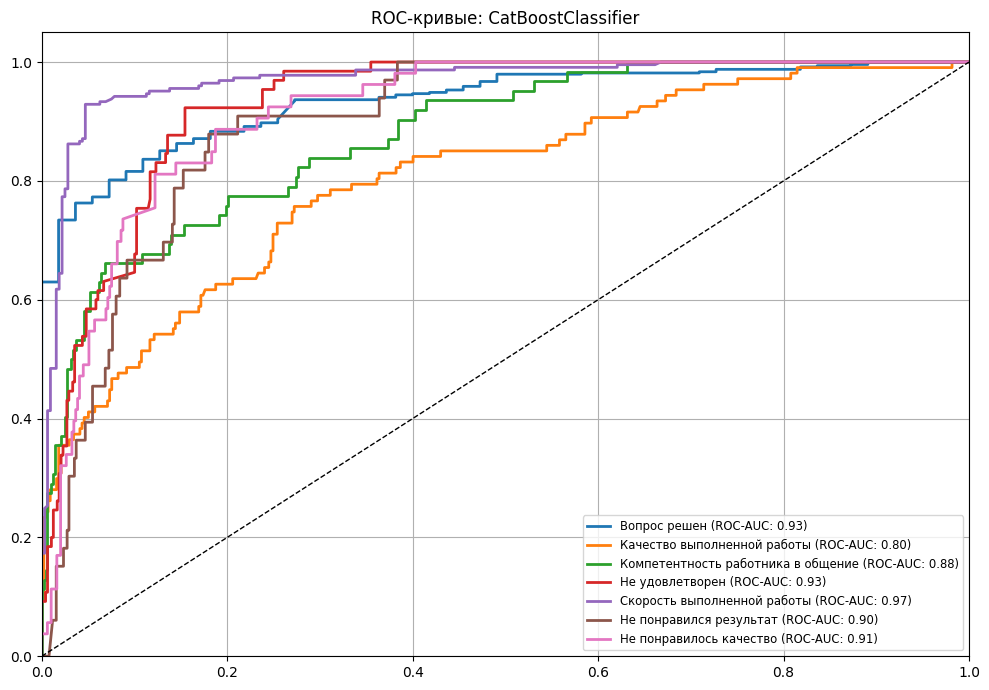

In [21]:
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: CatBoostClassifier')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

### Проверка работы модели

In [22]:
model = joblib.load("model/catboost_model.pkl")
vectorizer = joblib.load("model/tfidf_vectorizer.pkl")

labels = ['Вопрос решен', 'Качество выполненной работы', 'Компетентность работника в общение', 'Не удовлетворен', 'Скорость выполненной работы', 'Не понравился результат', 'Не понравилось качество']

def predict_labels(text, threshold=0.5):
    X = vectorizer.transform([text])
    # predict_proba для MultiOutputClassifier возвращает список массивов
    y_proba_list = model.predict_proba(X)
    # Получаем вероятности положительного класса (индекс 1)
    y_proba = np.array([proba[:, 1] for proba in y_proba_list]).T[0]
    result = {label: (prob > threshold) for label, prob in zip(labels, y_proba)}
    return result

if __name__ == "__main__":
    while True:
        text = input("Введите сообщение для классификации (или 'exit' для выхода):\n")
        if text.lower() == 'exit':
            break
        prediction = predict_labels(text)
        print("Категории, выставленные моделью:")
        for cat, val in prediction.items():
            if val:
                print(f" - {cat}")